## Import modules and functions

In [9]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio

## Define experiment directory

In [10]:
expdir='/Volumes/ukps-all$/user/tdanko/Students/' #master folder
protein="WFA" #TNR,Agg,WFA,HABP

## Make dictionary to store results, read images

In [11]:
results = {"filename":[],
           "ecmchannelno":[],"nucleichannelno":[],"synapsechannelno":[],"noblock_controldir":[],
           "Manual mask from matlab GUI":[],
           "exp condition":[],
           "ECM mean intensity after bg subtraction: matlab manual mask only":[]}

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "_analyse" in str(filelist[i]):
        if (protein in str(filelist[i]))==True:
            if ("TTX" in str(filelist[i]))==False:
                if filelist[i].endswith(".nd2"): 
                    results["filename"].append(filelist[i])
                    results["exp condition"].append(filelist[i].split('/')[-2])
                    channeldir="/".join(filelist[i].split("/")[:-2])
                    exec(open(channeldir+"/channels.txt").read())
                    results["ecmchannelno"].append(ecmchannelno)
                    results["nucleichannelno"].append(nucleichannelno)
                    results["synapsechannelno"].append(synapsechannelno)
                    positivecontrolcheck=Path(channeldir+"/Ctrl_NoBlocking")
                    if positivecontrolcheck.exists():
                        results["noblock_controldir"].append(channeldir+"/Ctrl_NoBlocking")                

## Display a random image from the filelist

Image name: 20181106_02_100x_002.nd2
Experimental condition: 12hrs_Bic


(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.]),
 <a list of 8 Text yticklabel objects>)

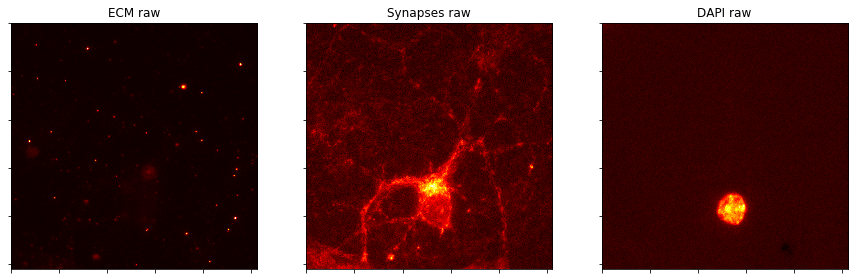

In [12]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
nuclei_channel_no=results["nucleichannelno"][randomno]
synapse_channel_no=results["synapsechannelno"][randomno]
with ND2Reader(results["filename"][randomno]) as images:
    print("Image name:",results["filename"][randomno].split('/')[-1])
    print("Experimental condition:",results["exp condition"][randomno])
    ecm_image=images[ecm_channel_no-1]
    nuclei_image=images[nuclei_channel_no-1]
    synapse_image=images[synapse_channel_no-1]
    ###the part below just checks what filter was used in the microscope for the channels
    ###from the image metadata
    [channel1name, channel2name, channel3name]=ecm_image.metadata['channels']
    if ecm_channel_no==1:
        ecm_channelname=channel1name
        if nuclei_channel_no==2:
            nuclei_channelname=channel2name
            synapse_channelname=channel3name
        else:
            nuclei_channelname=channel3name
            synapse_channelname=channel2name
    if ecm_channel_no==2:
        ecm_channelname=channel2name
        if nuclei_channel_no==3:
            nuclei_channelname=channel3name
            synapse_channelname=channel1name
        else:
            nuclei_channelname=channel1name
            synapse_channelname=channel3name
    if ecm_channel_no==3:
        ecm_channelname=channel3name
        if nuclei_channel_no==2:
            nuclei_channelname=channel2name
            synapse_channelname=channel1name
        else:
            nuclei_channelname=channel1name
            synapse_channelname=channel2name
figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
figure.add_subplot(132)
plt.imshow(synapse_image,interpolation='none',cmap='hot')
plt.title('Synapses raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
figure.add_subplot(133)
plt.imshow(nuclei_image,interpolation='none',cmap='hot')
plt.title('DAPI raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)

## Load manual masks drawn in Matlab GUI
- ROIs were manually drawn around neurites which appeared in focus and did not overlap with staining artifacts

In [13]:
for im in range(0,len(results["filename"])): 
    file=results["filename"][im][:-4]+'_mask.mat'
    from pathlib import Path
    my_file = Path(file)
    if my_file.exists():
        print(file)
        mat = spio.loadmat(file, squeeze_me=True)
        mask=mat['totMask']>0.99
        results["Manual mask from matlab GUI"].append(mask)
    else:
        results["Manual mask from matlab GUI"].append(np.nan)
clear_output()        
print("Done!")

Done!


## Visual a random masked image
- Background subtraction: subtract median filter of 5x5

Image name: 20181106_04_100x_002.nd2
Experimental condition: 12hrs_DMSO
ECM image - raw mean intensity =  503.60679626464844
ECM under manual mask - mean intensity =  621.3826544255281
ECM under manual rois mask - mean intensity after bg subtraction =  119.46500719126118


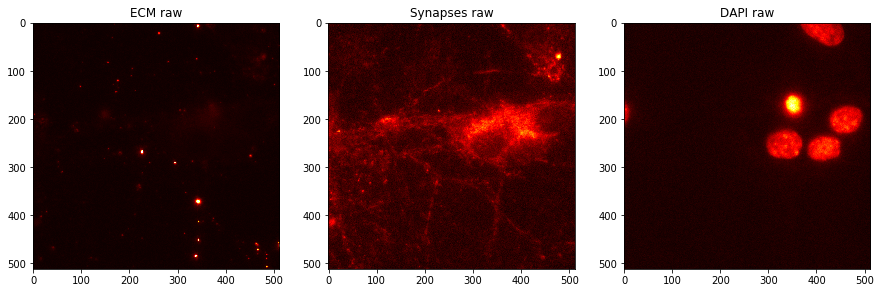

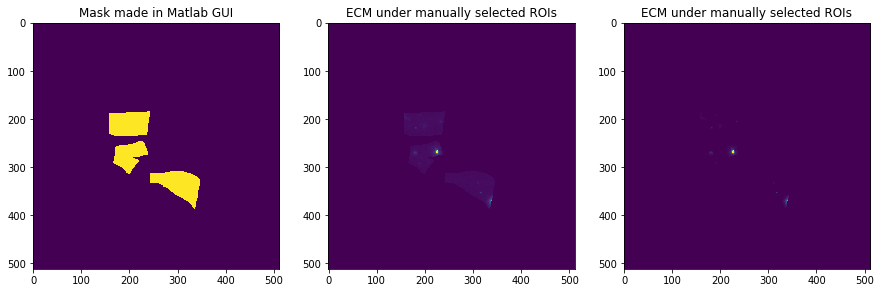

In [14]:
flag=False
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
nuclei_channel_no=results["nucleichannelno"][randomno]
synapse_channel_no=results["synapsechannelno"][randomno]
matlab_mask=results["Manual mask from matlab GUI"][randomno]

with ND2Reader(results["filename"][randomno]) as images:
    print("Image name:",results["filename"][randomno].split('/')[-1])
    print("Experimental condition:",results["exp condition"][randomno])
    ecm_image=images[ecm_channel_no-1]
    nuclei_image=images[nuclei_channel_no-1]
    synapse_image=images[synapse_channel_no-1]
    ###the part below just checks what filter was used in the microscope for the channels
    ###from the image metadata
    [channel1name, channel2name, channel3name]=ecm_image.metadata['channels']
    if ecm_channel_no==1:
        ecm_channelname=channel1name
        if nuclei_channel_no==2:
            nuclei_channelname=channel2name
            synapse_channelname=channel3name
        else:
            nuclei_channelname=channel3name
            synapse_channelname=channel2name
    if ecm_channel_no==2:
        ecm_channelname=channel2name
        if nuclei_channel_no==3:
            nuclei_channelname=channel3name
            synapse_channelname=channel1name
        else:
            nuclei_channelname=channel1name
            synapse_channelname=channel3name
    if ecm_channel_no==3:
        ecm_channelname=channel3name
        if nuclei_channel_no==2:
            nuclei_channelname=channel2name
            synapse_channelname=channel1name
        else:
            nuclei_channelname=channel1name
            synapse_channelname=channel2name
            
#make temporary masked images to show what we will keep
ecm_matlabmasked=deepcopy(ecm_image)
synapses_matlabmasked=deepcopy(synapse_image)
if type(matlab_mask)==np.ndarray:
    ecm_matlabmasked[~matlab_mask]=0
    synapses_matlabmasked[~matlab_mask]=0
    flag=True

figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
figure.add_subplot(132)
plt.imshow(synapse_image,interpolation='none',cmap='hot')
plt.title('Synapses raw')
figure.add_subplot(133)
plt.imshow(nuclei_image,interpolation='none',cmap='hot')
plt.title('DAPI raw')

#show masks
fig=plt.figure(figsize=(15,15))
fig.add_subplot(131)
if flag==True:
    plt.imshow(matlab_mask)
    plt.title('Mask made in Matlab GUI')
else:
    plt.imshow(np.zeros([512,512]))
    plt.title('Mask made in Matlab GUI - no mask was made') 
fig.add_subplot(132)
if flag==True:
    plt.imshow(ecm_matlabmasked)
    plt.title('ECM under manually selected ROIs')
else:
    plt.imshow(ecm_matlabmasked)
    plt.title('No manual mask was made') 

#background subtraction    
ecm_matlabmasked_bgreduced=deepcopy(ecm_image)
if flag==True:
    bg_matlabmask=np.mean(ndi.median_filter(ecm_image[matlab_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[matlab_mask],size=5))
    ecm_matlabmasked_bgreduced=np.subtract(ecm_matlabmasked_bgreduced,bg_matlabmask)
    ecm_matlabmasked_bgreduced[ecm_matlabmasked_bgreduced<0]=0
    ecm_matlabmasked_bgreduced[~matlab_mask]=0
fig.add_subplot(133)
if flag==True:
    plt.imshow(ecm_matlabmasked_bgreduced)
    plt.title('ECM under manually selected ROIs')
else:
    plt.imshow(ecm_matlabmasked_bgreduced)
    plt.title('No manual mask was made')
#calculate intensities before/after bg subtraction
print('ECM image - raw mean intensity = ',np.nanmean(ecm_image))
if flag==True:
    print('ECM under manual mask - mean intensity = ',np.nanmean(ecm_image[matlab_mask]))
    print('ECM under manual rois mask - mean intensity after bg subtraction = ', np.nanmean(ecm_matlabmasked_bgreduced[matlab_mask]))

## Batch analyse the images

In [15]:
print('Total number of images: ' + str(len(results['filename'])))

for i in range(0,len(results["filename"])): 
    print('Calculating image no ' + str(i+1) + ' out of' + str(len(results["filename"])))
    #read the image
    ecm_channel_no=results["ecmchannelno"][i]
    nuclei_channel_no=results["nucleichannelno"][i]
    synapse_channel_no=results["synapsechannelno"][i]
    with ND2Reader(results["filename"][i]) as images:
        ecm_image=images[ecm_channel_no-1]
        nuclei_image=images[nuclei_channel_no-1]
        synapse_image=images[synapse_channel_no-1]
    #convert to numpy array 
    ecm_image=ecm_image.astype(np.int16)
    nuclei_image=nuclei_image.astype(np.int16)
    synapse_image=synapse_image.astype(np.int16)
    #read masks from matlab GUI
    matlab_mask=results["Manual mask from matlab GUI"][i]
    if type(matlab_mask)==np.ndarray:
        flag=True
    #background subtraction
    ecm_matlabmasked_bgreduced=deepcopy(ecm_image)
    if flag==True:
        bg_matlabmask=np.mean(ndi.median_filter(ecm_image[matlab_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[matlab_mask],size=5))
        ecm_matlabmasked_bgreduced=np.subtract(ecm_matlabmasked_bgreduced,bg_matlabmask)
        ecm_matlabmasked_bgreduced[ecm_matlabmasked_bgreduced<0]=0
        ecm_matlabmasked_bgreduced[~matlab_mask]=0
    #append the final results to the dictionary:
    if flag==True:
        results["ECM mean intensity after bg subtraction: matlab manual mask only"].append(np.nanmean(ecm_matlabmasked_bgreduced[matlab_mask]))
    else:
        results["ECM mean intensity after bg subtraction: matlab manual mask only"].append(np.nan)
    clear_output()
    flag=False
os.system('say "Finished batch analyzing"')
print('Done!')

Done!


## Make dataframe of results for visualization and statistical analysis

In [16]:
df=pd.DataFrame(results)
df['expname']=filelist[i].split("/")[:-2][-1]#add exp id
df2=deepcopy(df)
df2['Time']='None'
df2.loc[df2['exp condition'].str.contains('2hr'), 'Time'] = '2hrs'
df2.loc[df2['exp condition'].str.contains('12hrs'), 'Time'] = '12hrs'
df2.loc[df2['exp condition'].str.contains('4hrs'), 'Time'] = '4hrs'
df2.loc[df2['exp condition'].str.contains('22hrs'), 'Time'] = '22hrs'
df2.loc[df2['exp condition'].str.contains('Ctrl'), 'Time'] = 'No Blocking'
df2.loc[df2['exp condition'].str.contains('Bic'), 'Drug'] = 'Bic'
df2.loc[df2['exp condition'].str.contains('DMSO'), 'Drug'] = 'DMSO'
df2.loc[df2['exp condition'].str.contains('Ctrl'), 'Drug'] = 'DMSO'
#nicely written treatment condition for plotting
df2['Condition']='None'
df2.loc[df2['exp condition'].str.contains('Ctrl'), 'Condition'] = 'No Blocking'
df2.loc[df2['exp condition'].str.contains('2hrs_Bic'), 'Condition'] = '2hr + Bic'
df2.loc[df2['exp condition'].str.contains('2hr_Bic'), 'Condition'] = '2hr + Bic'
df2.loc[df2['exp condition'].str.contains('2hrs_DMSO'), 'Condition'] = '2hr'
df2.loc[df2['exp condition'].str.contains('4hrs_Bic'), 'Condition'] = '4hr + Bic'
df2.loc[df2['exp condition'].str.contains('4hrs_DMSO'), 'Condition'] = '4hr'
df2.loc[df2['exp condition'].str.contains('12hrs_Bic'), 'Condition'] = '12hr + Bic'
df2.loc[df2['exp condition'].str.contains('12hrs_DMSO'), 'Condition'] = '12hr'
#experimental or control
df2['ExporCtrl']='None'
df2.loc[df2['exp condition'].str.contains('2hr'), 'ExporCtrl'] = 'Exp'
df2.loc[df2['exp condition'].str.contains('12hrs'), 'ExporCtrl'] = 'Exp'
df2.loc[df2['exp condition'].str.contains('4hrs'), 'ExporCtrl'] = 'Exp'
df2.loc[df2['exp condition'].str.contains('22hrs'), 'ExporCtrl'] = 'Exp'
df2.loc[df2['exp condition'].str.contains('Ctrl'), 'ExporCtrl'] = 'Ctrl'

for i in range(0,len(df2)):
    df2['expname'][i]=df2["filename"][i].split("/")[:-2][-1]

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Make a dataframe where each datapoint is the mean of a single experiment

In [17]:
var="ECM mean intensity after bg subtraction: matlab manual mask only" #change me

means={"expname":[],"Time":[],"intensity normd 0 to 1":[], "0 to 1 intensity normd to unblocked mean":[],
      "intensity normd to 2hr":[]}

df2read=df2[(df2["Drug"]!="Bic")] #disclude bic treated cultures from the analysis of 2, 4, 12h increase

for exp in df2read["expname"].unique():
    dfcalc=df2read[df2read["expname"]==exp]
    
    means["expname"].append(exp)
    means["Time"].append('No Blocking')
    dfcalc2=dfcalc[dfcalc["Time"]=="No Blocking"]
    diomean=dfcalc2[var].mean()
    means["intensity normd 0 to 1"].append(diomean)
    means["0 to 1 intensity normd to unblocked mean"].append(1)
    #means["intensity normd to 2hr"].append(np.nan)
    
    means["expname"].append(exp)
    means["Time"].append('2hrs')
    dfcalc2=dfcalc[dfcalc["Time"]=="2hrs"]
    twelvemean=dfcalc2[var].mean()
    means["intensity normd 0 to 1"].append(dfcalc2[var].mean())
    means["0 to 1 intensity normd to unblocked mean"].append(dfcalc2[var].mean()/diomean)    
    
    means["intensity normd to 2hr"].append(diomean/twelvemean)
    means["intensity normd to 2hr"].append(1)
    
    means["expname"].append(exp)
    means["Time"].append('4hrs')
    dfcalc2=dfcalc[dfcalc["Time"]=="4hrs"]
    means["intensity normd 0 to 1"].append(dfcalc2[var].mean())
    means["0 to 1 intensity normd to unblocked mean"].append(dfcalc2[var].mean()/diomean)
    means["intensity normd to 2hr"].append(dfcalc2[var].mean()/twelvemean)
    
    means["expname"].append(exp)
    means["Time"].append('12hrs')
    dfcalc2=dfcalc[dfcalc["Time"]=="12hrs"]
    means["intensity normd 0 to 1"].append(dfcalc2[var].mean())
    means["0 to 1 intensity normd to unblocked mean"].append(dfcalc2[var].mean()/diomean)
    means["intensity normd to 2hr"].append(dfcalc2[var].mean()/twelvemean)
    
dfmeans=pd.DataFrame(means)

## Statistics
- t tests with Bonferroni correction

In [18]:
var="intensity normd to 2hr"

unblocked=dfmeans[dfmeans["Time"]=="No Blocking"][var].dropna().values
twohr=dfmeans[dfmeans["Time"]=="2hrs"][var].dropna().values
fourhr=dfmeans[dfmeans["Time"]=="4hrs"][var].dropna().values
twelvehr=dfmeans[dfmeans["Time"]=="12hrs"][var].dropna().values

[stat,pval_2_12]=stats.ttest_ind(twohr, twelvehr)

print(' normd to 2 - 2 and 12 '+str(pval_2_12))

 normd to 2 - 2 and 12 0.03612940554136931


## Plot 2, 12, unblocked

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


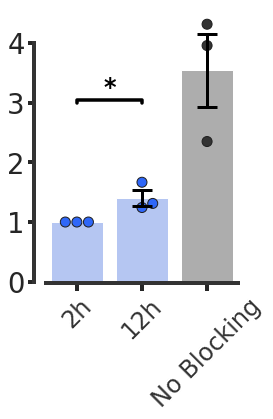

In [19]:
dfmeans=dfmeans.dropna()
sns.set(font_scale=2.5)
sns.set_style("ticks")

var="intensity normd to 2hr"
fig=plt.figure(figsize=(3.5,5))
order=['2hrs','12hrs','No Blocking']
palette ={"No Blocking":"white","2hrs":"#2F67F8","4hrs":"#2F67F8","12hrs":"#2F67F8"}
paletteswarm ={"No Blocking":"#333333","2hrs":"#2F67F8","4hrs":"#2F67F8","12hrs":"#2F67F8"}
edges ={"No Blocking":"gray","2hrs":"#2F67F8","4hrs":"#2F67F8","12hrs":"#2F67F8"}
palettes ={"No Blocking":"#adadad","2hrs":"#abc2fc","4hrs":"#abc2fc","12hrs":"#abc2fc"}

g=sns.barplot(x="Time",y=var,data=dfmeans,alpha=1,ci=None,palette=palettes,order=order)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(g, .8)

g=sns.swarmplot(x="Time",y=var,data=dfmeans,size=10,palette=paletteswarm,linewidth=1,order=order)

plt.errorbar(x=[2,1],
             y=[dfmeans[dfmeans["Time"]=="No Blocking"][var].mean(),
             dfmeans[dfmeans["Time"]=="12hrs"][var].mean()],
             yerr=[dfmeans[dfmeans["Time"]=="No Blocking"][var].sem(),
             dfmeans[dfmeans["Time"]=="12hrs"][var].sem()],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

plt.ylim([-0.05,4.5])
plt.axhline(-0.08, color='#333333',alpha=1,linewidth=12)
plt.yticks([0,1,2,3,4],color='#333333')
plt.xticks(g.get_xticks(),['2h','12h','No Blocking'],color='#333333',size=20)
g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)
plt.rcParams['font.sans-serif'] = 'Helvetica'

for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),size=24,rotation=45,color='#333333')
g.grid(False)

x1, x2 = 0,1
y= 3
h=0.01*dfmeans[var].max()
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=24, weight='bold')

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'2b_ncanincreases.svg', bbox_inches='tight', format='svg')

## Make dataframe of separate images for Bic vs DMSO images
- normalised to DMSO
- 12h timepoint

In [20]:
var="ECM mean intensity after bg subtraction: matlab manual mask only"
df2showi=df2[(df2["Time"]=="12hrs")]
df2showi=df2showi.reset_index(drop=True)
df2showi["intnorm2dmso"]=np.nan
df2showi_exps=[]
df2showi_exps_12hrdmsomean=[]
for exp in df2showi["expname"].unique():
    df2showi_exp=df2showi[df2showi["expname"]==exp]
    mean_12hrdmso=df2showi_exp[df2showi_exp["Drug"]=="DMSO"][var].mean()
    df2showi_exps_12hrdmsomean.append(mean_12hrdmso)
    df2showi_exps.append(exp)
for i in range(0,len(df2showi)):
    if df2showi["expname"][i]==df2showi_exps[0]:
        df2showi["intnorm2dmso"][i]=df2showi[var][i]/df2showi_exps_12hrdmsomean[0]
    if df2showi["expname"][i]==df2showi_exps[1]:
        df2showi["intnorm2dmso"][i]=df2showi[var][i]/df2showi_exps_12hrdmsomean[1]
    if df2showi["expname"][i]==df2showi_exps[2]:
        df2showi["intnorm2dmso"][i]=df2showi[var][i]/df2showi_exps_12hrdmsomean[2]

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Statistics
- t tests with Bonferonni corrections

In [21]:
var="intnorm2dmso"
dmso=df2showi[df2showi["Drug"]=="DMSO"][var].dropna().values
bic=df2showi[df2showi["Drug"]=="Bic"][var].dropna().values

[stat,pval]=stats.ttest_ind(dmso, bic)
print(pval)

0.03926367548865848


## Plot Bic vs DMSO at 12h

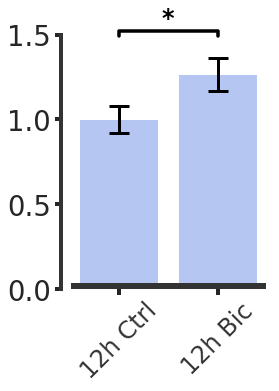

In [22]:
from matplotlib import ticker
sns.set(font_scale=2.5)
sns.set_style("ticks")

var="intnorm2dmso"

fig=plt.figure(figsize=(3.5,5))

order=['DMSO','Bic']
palette ={"No Blocking":"white","2hrs":"#2F67F8","4hrs":"#2F67F8","12hrs":"#2F67F8"}
paletteswarm ={"No Blocking":"#333333","2hrs":"#2F67F8","4hrs":"#2F67F8","12hrs":"#2F67F8"}
edges ={"No Blocking":"gray","2hrs":"#2F67F8","4hrs":"#2F67F8","12hrs":"#2F67F8"}
palettes ={"No Blocking":"#adadad","2hrs":"#abc2fc","4hrs":"#abc2fc","12hrs":"#abc2fc"}

g=sns.barplot(x="Drug",y=var,data=df2showi,alpha=1,ci=None,color="#abc2fc",order=order)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
change_width(g, .8)
plt.errorbar(x=[0,1],
             y=[df2showi[df2showi["Drug"]==drug][var].mean() for drug in order],             
             yerr=[df2showi[df2showi["Drug"]==drug][var].sem() for drug in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

plt.ylim([0,1.6])
plt.axhline(0, color='#333333',alpha=1,linewidth=12)
plt.xticks(g.get_xticks(),['12h Ctrl','12h Bic'],color='#333333',size=20)
g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)
plt.rcParams['font.sans-serif'] = 'Helvetica'
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets) 
g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),size=24,rotation=45,color='#333333')
g.grid(False)

x1, x2 = 0,1
y= 1.49
h=0.01*df2showi[var].max()
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=24, weight='bold')

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'supp4_ncanincreasesbic.svg', bbox_inches='tight', format='svg')

## Number of neurons imaged for bic/dmso

In [23]:
len(bic)+len(dmso)

59